In [1]:
# This is an example GPT style decoder only transformer model and example dataset
# This an example of the use of the icanswim/cosmosis repo for data science and 
# machine learning projects

import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

from dataset import TinyShakes

from cosmosis.model import GPT
from cosmosis.dataset import AsTensor
from cosmosis.learning import Learn, Selector, Metrics

from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [2]:
ds_param = {'transforms': {'X1': [AsTensor()],
                           'X2': [AsTensor()]},
            'block_size': 6,
            'n': 1}

ts = TinyShakes(**ds_param)
print(ts[0])
print(ts[0]['X1'].shape)
print(ts[0]['X2'].shape)

tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyskakes_encoded.bin
len(self.ds_idx):  1
data.nbytes:  676050
CDataset created...
{'X1': tensor([ 5962, 22307,    25,   198,  8421,   356]), 'X2': tensor([22307,    25,   198,  8421,   356,  5120])}
torch.Size([6])
torch.Size([6])


In [3]:
ds_param = {'transforms': {'X1': [AsTensor()],
                           'X2': [AsTensor()]},
            'block_size': 6,
            'prompt': '1 2 3 4 5 6 7 8 9 10'}

ts_infer = TinyShakes(**ds_param)
print(ts_infer[0])
print(ts_infer[0]['X1'].shape)
print(ts_infer[0]['X2'].shape)

len(self.ds_idx):  1
data.nbytes:  20
CDataset created...
{'X1': tensor([ 16, 362, 513, 604, 642, 718]), 'X2': tensor([362, 513, 604, 642, 718, 767])}
torch.Size([6])
torch.Size([6])


In [4]:
# load model
model_param = {'device': 'cpu',
               'd_model': 32, # matches embedding dimension
               'd_vocab': 50304, # matches embedding vocab
               'n_head': 2, 
               'num_layers': 2,
               'linear_head': True,
               'probs': False, # softmax
               'tokens': False, # multinomial
               'transpose': False, 
               'embed_param': {'X1': (50304, 32, None, True),
                               'X2': (50304, 32, None, True)}} 

gpt = GPT(model_param)

CModel loaded...


In [5]:
# load single data example into model and examine output
data = ts_infer[0]
out = gpt(data)
print(out)
print(out.shape)
print(out.dtype)

tensor([[ 0.2514,  0.0000, -0.0400,  ..., -0.7752,  1.4809,  0.0000],
        [-0.7551,  0.3159, -0.8596,  ..., -0.1780,  1.1089,  0.4158],
        [-0.8491,  0.2715, -0.5409,  ...,  0.3434,  0.2263, -0.8506],
        [-0.1524,  0.4755, -0.9839,  ...,  0.4668,  0.6346,  1.1039],
        [ 0.6630, -0.2519, -0.5125,  ..., -0.1951,  0.7733,  1.4637],
        [ 0.8072, -1.0922,  0.3838,  ..., -0.4841, -0.4446,  0.3541]],
       grad_fn=<MulBackward0>)
torch.Size([6, 50304])
torch.float32


In [6]:
# load generated logits and target tokens into loss function
cel_func = CrossEntropyLoss()
prompt_tokens = data['X2']
print('prompt_tokens: ', prompt_tokens, prompt_tokens.shape, prompt_tokens.dtype)

target_tokens = data['X1']
target_tokens.unsqueeze(0)
print('target_tokens: ', target_tokens, target_tokens.shape, target_tokens.dtype)

generated_tokens = out
generated_tokens.unsqueeze(0)
print('generated_tokens: ', generated_tokens.unsqueeze(0), generated_tokens.shape, generated_tokens.dtype)

loss = cel_func(generated_tokens, target_tokens)
print('loss: ', loss)

prompt_tokens:  tensor([362, 513, 604, 642, 718, 767]) torch.Size([6]) torch.int64
target_tokens:  tensor([ 16, 362, 513, 604, 642, 718]) torch.Size([6]) torch.int64
generated_tokens:  tensor([[[ 0.2514,  0.0000, -0.0400,  ..., -0.7752,  1.4809,  0.0000],
         [-0.7551,  0.3159, -0.8596,  ..., -0.1780,  1.1089,  0.4158],
         [-0.8491,  0.2715, -0.5409,  ...,  0.3434,  0.2263, -0.8506],
         [-0.1524,  0.4755, -0.9839,  ...,  0.4668,  0.6346,  1.1039],
         [ 0.6630, -0.2519, -0.5125,  ..., -0.1951,  0.7733,  1.4637],
         [ 0.8072, -1.0922,  0.3838,  ..., -0.4841, -0.4446,  0.3541]]],
       grad_fn=<UnsqueezeBackward0>) torch.Size([6, 50304]) torch.float32
loss:  tensor(10.6567, grad_fn=<NllLossBackward0>)


tinyshakes.txt loaded from saved file in ../gpt/data/
tokens loaded from file ./data/tinyskakes_encoded.bin
len(self.ds_idx):  1000
data.nbytes:  676050
CDataset created...
CModel loaded...
running model on gpu...

...........................
learning time: 0:00:02.969337
epoch: 0, lr: 0.01
train loss: 0.35833285457786473, val loss: 0.3166855010721419

last targets: 
,Now comes the sick hour that dearer merit, not so

last predictions: 
,,,,::


...........................
learning time: 0:00:04.876573
last predictions: 
,,,
,,

last targets: 
elays;
My, old Lancaster hath spent.No, at a word,
test loss: 0.3265366388691796 



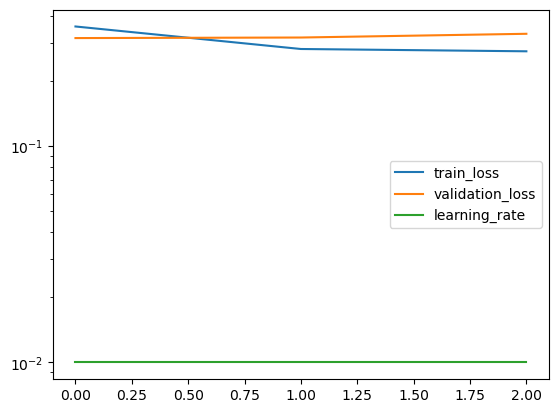

In [2]:
# put all together in a learner
ds_param = {'train_param': {'transforms': {'X1': [AsTensor()],
                                           'X2': [AsTensor()]},
                            'block_size': 6,
                            'n': 1000}}

model_param = {'device': 'cuda',
               'd_model': 32, # matches embedding dimension
               'd_vocab': 50304, # matches embedding vocab
               'n_head': 4, 
               'num_layers': 3,
               'linear_head': True,
               'probs': False,
               'tokens': False,
               'transpose': True, 
               'embed_param': {'X1': (50304, 32, None, True),
                               'X2': (50304, 32, None, True)}} 
                                       
metrics_param = {'metric_name': 'transformer',
                 'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .005} # break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=CrossEntropyLoss,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=24, epochs=3, gpu=True, squeeze_y_pred=True, 
              save_model='gpt_test_model', target='X1')

In [3]:
# inference
ds_param = {'train_param': {'transforms': {'X1': [AsTensor()],
                                           'X2': [AsTensor()]},
                            'block_size': 6,
                            'prompt': '1 2 3 4 5 6 7 8 9 10'}}

model_param = {'device': 'cuda',
               'd_model': 32, # matches embedding dimension
               'd_vocab': 50304, # matches embedding vocab
               'n_head': 4, 
               'num_layers': 3,
               'linear_head': True,
               'probs': False,
               'tokens': False,
               'transpose': True, 
               'embed_param': {'X1': (50304, 32, None, True),
                               'X2': (50304, 32, None, True)}} 

                                       
metrics_param = {'metric_name': 'transformer',
                 'report_interval': 10,
                 'log_plot': True,
                 'min_lr': .005} # break if learning rate falls below                        
             
opt_param = {'lr': 0.01}

crit_param = {}

sample_param = {'set_seed': 88,
                'splits': (.7,.15)}

sched_param = {'factor': .5, 
               'patience': 2,
               'cooldown': 2}

learn = Learn([TinyShakes], 
              GPT,
              Metrics=Metrics,
              Sampler=Selector, 
              Optimizer=Adam, 
              Scheduler=ReduceLROnPlateau, 
              Criterion=None,
              model_param=model_param, ds_param=ds_param, sample_param=sample_param,
              opt_param=opt_param, sched_param=sched_param, crit_param=crit_param,
              metrics_param=metrics_param, 
              batch_size=1, epochs=1, gpu=True, squeeze_y_pred=True, 
              load_model='gpt_test_model.pth', target='X1')


len(self.ds_idx):  1
data.nbytes:  20
CDataset created...
CModel loaded...
model loaded from state_dict...
running model on gpu...

...........................
learning time: 0:00:00.069848
last predictions: 
$

inference 2024-12-24 11:21:39.040728 complete and saved to csv...


In [4]:
learn.metrics.predictions

['$']